# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [2]:
output_featimp = 'feat_xgb_v17_reglinear_logy1.csv'
output_sub     = 'sub_xgb_v17_reglinear_logy1.csv'
output_oof     = 'oof_xgb_v17_reglinear_logy1.csv'

shift = 1

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 5
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'reg:linear', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [4]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = np.log(train_df[TARGET]+shift)

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_41208\43068727.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_41208\43068727.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [5]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [6]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [7]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [8]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [9]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [10]:
## OOF target
oof_nfolds = 10

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_41208\1776465337.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_41208\1776465337.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [12]:
# modeling with cross validation
# kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
kfold = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = np.exp(model.predict(d_valid, ntree_limit=model.best_ntree_limit))-shift
    oof_test_skf[fold_id, :] = np.exp(model.predict(d_test, ntree_limit=model.best_ntree_limit))-shift

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, np.exp(y_train)-shift)))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], np.exp(y_train[0:24069])-shift)))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], np.exp(y_train[24069:])-shift)))


Fold 1 / 5
[18:31:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.60082	eval-rmse:2.57770
[100]	train-rmse:1.24936	eval-rmse:1.32471
[200]	train-rmse:0.79935	eval-rmse:0.98338
[300]	train-rmse:0.63795	eval-rmse:0.90469
[400]	train-rmse:0.56635	eval-rmse:0.88615
[500]	train-rmse:0.52560	eval-rmse:0.88011
[600]	train-rmse:0.49661	eval-rmse:0.87721
[700]	train-rmse:0.47562	eval-rmse:0.87567
[800]	train-rmse:0.45871	eval-rmse:0.87484
[900]	train-rmse:0.44045	eval-rmse:0.87426
[1000]	train-rmse:0.42384	eval-rmse:0.87375
[1086]	train-rmse:0.40972	eval-rmse:0.87364


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 2 / 5
[18:32:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.58903	eval-rmse:2.62528
[100]	train-rmse:1.24487	eval-rmse:1.35252
[200]	train-rmse:0.79766	eval-rmse:1.00439
[300]	train-rmse:0.63918	eval-rmse:0.92337
[400]	train-rmse:0.56909	eval-rmse:0.90378
[500]	train-rmse:0.52825	eval-rmse:0.89770
[600]	train-rmse:0.50007	eval-rmse:0.89478
[700]	train-rmse:0.47897	eval-rmse:0.89319
[800]	train-rmse:0.46073	eval-rmse:0.89214
[900]	train-rmse:0.44503	eval-rmse:0.89131
[1000]	train-rmse:0.42968	eval-rmse:0.89089
[1100]	train-rmse:0.41437	eval-rmse:0.89056
[1189]	train-rmse:0.40247	eval-rmse:0.89059

Fold 3 / 5
[18:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.60058	eval-rmse:2.57848


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:1.25097	eval-rmse:1.30736
[200]	train-rmse:0.79903	eval-rmse:0.97041
[300]	train-rmse:0.63598	eval-rmse:0.89963
[400]	train-rmse:0.56436	eval-rmse:0.88548
[500]	train-rmse:0.52458	eval-rmse:0.88112
[600]	train-rmse:0.49806	eval-rmse:0.87914
[700]	train-rmse:0.47697	eval-rmse:0.87799
[800]	train-rmse:0.46008	eval-rmse:0.87754
[900]	train-rmse:0.44320	eval-rmse:0.87702
[1000]	train-rmse:0.42665	eval-rmse:0.87651
[1100]	train-rmse:0.41098	eval-rmse:0.87628
[1170]	train-rmse:0.40162	eval-rmse:0.87631

Fold 4 / 5
[18:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.59314	eval-rmse:2.60906


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:1.24517	eval-rmse:1.35156
[200]	train-rmse:0.79474	eval-rmse:1.01164
[300]	train-rmse:0.63478	eval-rmse:0.93199
[400]	train-rmse:0.56369	eval-rmse:0.91299
[500]	train-rmse:0.52345	eval-rmse:0.90719
[600]	train-rmse:0.49620	eval-rmse:0.90429
[700]	train-rmse:0.47598	eval-rmse:0.90277
[800]	train-rmse:0.45719	eval-rmse:0.90208
[900]	train-rmse:0.44051	eval-rmse:0.90171
[1000]	train-rmse:0.42391	eval-rmse:0.90145
[1100]	train-rmse:0.40984	eval-rmse:0.90130
[1200]	train-rmse:0.39508	eval-rmse:0.90113
[1211]	train-rmse:0.39369	eval-rmse:0.90109

Fold 5 / 5
[18:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.59700	eval-rmse:2.59329


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:1.24824	eval-rmse:1.33785
[200]	train-rmse:0.79902	eval-rmse:0.99596
[300]	train-rmse:0.63974	eval-rmse:0.91635
[400]	train-rmse:0.56828	eval-rmse:0.89721
[500]	train-rmse:0.52542	eval-rmse:0.89137
[600]	train-rmse:0.49633	eval-rmse:0.88896
[700]	train-rmse:0.47324	eval-rmse:0.88783
[800]	train-rmse:0.45632	eval-rmse:0.88713
[900]	train-rmse:0.43971	eval-rmse:0.88686
[906]	train-rmse:0.43905	eval-rmse:0.88681

OOF RMSE: 855.3811
OOF RMSE in 0:24069:   153.4916
OOF RMSE in 24069:END: 2779.9746


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0, 0.5, 'actual')

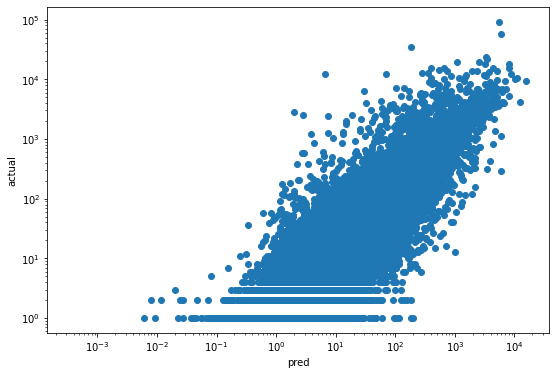

In [17]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, np.exp(y_train)-shift)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

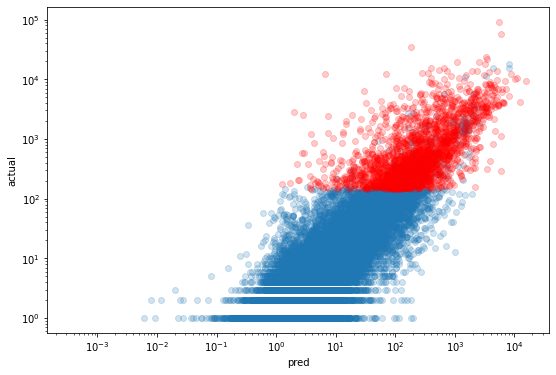

In [18]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], np.exp(y_train[0:24069])-shift, alpha=0.2)
plt.scatter(oof_train[24069:], np.exp(y_train[24069:])-shift, alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [19]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [20]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END